In [1]:
!pip install -U transformers peft accelerate scikit-learn matplotlib pandas torch seaborn

In [2]:
import pandas as pd
import numpy as np
import torch
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding,
    pipeline
)

from peft import LoraConfig, get_peft_model, TaskType

In [3]:
df = pd.read_csv("/content/sample_data/TokopediaLocknLock.csv")
df = df.rename(columns={df.columns[0]: "text"})

print("Jumlah data awal:", len(df))
df.head()

Jumlah data awal: 10276


,text
0,bahan botol tipis. setauku pet 1 hanya diguna...
1,"Materialnya bagus, tahan lama, ga gampang rusa..."
2,packing aman ya dan botol ada plastik pembungk...
3,kualitas top. model easy grip sangat OK. packi...
4,Kaget pas datang paketnya dalam dus gede bange...


In [4]:
def clean_text(text):
    text = str(text).lower()                      # lowercase
    text = re.sub(r"http\S+", "", text)           # hapus URL
    text = re.sub(r"@\w+", "", text)              # hapus mention
    text = re.sub(r"#\w+", "", text)              # hapus hashtag
    text = re.sub(r"[^a-zA-Z\s]", "", text)       # hapus simbol & angka
    text = re.sub(r"\s+", " ", text).strip()      # hapus spasi berlebih
    return text

df["clean_text"] = df["text"].apply(clean_text)

# Filter Teks Kosong / Terlalu Pendek
df = df[df["clean_text"].str.strip().str.len() > 3].reset_index(drop=True)

print("Jumlah data setelah preprocessing:", len(df))

Jumlah data setelah preprocessing: 10260


In [5]:
# Simpan versi asli
df["raw_text"] = df["text"]

# Terapkan preprocessing ke kolom baru
df["clean_text"] = df["text"].astype(str).apply(clean_text)

# Membandingkan sebelum dan sesudah preprocessing
sample = df.sample(5, random_state=42)

for i, row in sample.iterrows():
    print("SEBELUM :", row["raw_text"])
    print("SESUDAH :", row["clean_text"])
    print("-" * 80)

SEBELUM : Pengemasan baik. Dus dan botol tidak cacat. Pengiriman cepat. Terima kasih sekali.
SESUDAH : pengemasan baik dus dan botol tidak cacat pengiriman cepat terima kasih sekali
--------------------------------------------------------------------------------
SEBELUM : bgs banget botol ny...mksh banyak tokopedia
SESUDAH : bgs banget botol nymksh banyak tokopedia
--------------------------------------------------------------------------------
SEBELUM : Pengiminan cepat dan packing nya aman. produknya bagus. Bahannya tebal. Sayangnya nggak ada uk besar.
SESUDAH : pengiminan cepat dan packing nya aman produknya bagus bahannya tebal sayangnya nggak ada uk besar
--------------------------------------------------------------------------------
SEBELUM : Sesuai deskripsi pokoknya mantaplah
SESUDAH : sesuai deskripsi pokoknya mantaplah
--------------------------------------------------------------------------------
SEBELUM : produk bagus, tahan panas lama
SESUDAH : produk bagus tahan panas l

In [6]:
sentiment_pipe = pipeline(
    "sentiment-analysis",
    model="w11wo/indonesian-roberta-base-sentiment-classifier",
    device=0 if torch.cuda.is_available() else -1
)

def auto_label(text):
    if text.strip() == "":
        return "neutral"
    result = sentiment_pipe(text[:512])[0]["label"].lower()
    return result

df["label"] = df["clean_text"].apply(auto_label)
print(df["label"].value_counts())

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


label
positive    8950
negative    1046
neutral      264
Name: count, dtype: int64


In [7]:
label_encoder = LabelEncoder()
df["label_id"] = label_encoder.fit_transform(df["label"])

num_labels = len(label_encoder.classes_)
print("Label map:", dict(enumerate(label_encoder.classes_)))

Label map: {0: 'negative', 1: 'neutral', 2: 'positive'}


In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(
    df["clean_text"],
    df["label_id"],
    test_size=0.30,
    random_state=42,
    stratify=df["label_id"]
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

In [9]:
model_name = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_enc = tokenizer(list(X_train), truncation=True)
val_enc   = tokenizer(list(X_val), truncation=True)
test_enc  = tokenizer(list(X_test), truncation=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [10]:
class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.tolist()

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ReviewDataset(train_enc, y_train)
val_dataset   = ReviewDataset(val_enc, y_val)
test_dataset  = ReviewDataset(test_enc, y_test)

In [11]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print("Class Weights :", class_weights)

Class Weights : tensor([ 3.2705, 12.9405,  0.3821])


In [12]:
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1
)

In [13]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }

In [16]:
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights.to(logits.device))
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [17]:
experiment_configs = [
    {"epochs": 5,  "lr": 2e-5, "batch_size": 16},
    {"epochs": 5,  "lr": 2e-5, "batch_size": 32},
    {"epochs": 10, "lr": 2e-5, "batch_size": 16},
    {"epochs": 10, "lr": 2e-5, "batch_size": 32},
    {"epochs": 5,  "lr": 3e-5, "batch_size": 16},
    {"epochs": 5,  "lr": 3e-5, "batch_size": 32},
    {"epochs": 10, "lr": 3e-5, "batch_size": 16},
    {"epochs": 10, "lr": 3e-5, "batch_size": 32}
]

experiment_results = []

for i, cfg in enumerate(experiment_configs, 1):
    print(f"\n=== Experiment {i} | Epoch {cfg['epochs']} | "
          f"LR {cfg['lr']} | Batch {cfg['batch_size']} ===")

    # Load model fresh setiap eksperimen
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name,
        num_labels=len(label_encoder.classes_)
    )

    model = get_peft_model(model, lora_config)

    training_args = TrainingArguments(
        output_dir=f"./exp_{i}",
        per_device_train_batch_size=cfg["batch_size"],
        per_device_eval_batch_size=cfg["batch_size"],
        num_train_epochs=cfg["epochs"],
        learning_rate=cfg["lr"],
        eval_strategy="epoch",
        save_strategy="no",
        logging_steps=100,
        report_to="none"
    )

    trainer = WeightedTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=DataCollatorWithPadding(tokenizer),
        compute_metrics=compute_metrics
    )

    trainer.train()
    eval_result = trainer.evaluate()

    experiment_results.append({
        "experiment": i,
        "epochs": cfg["epochs"],
        "learning_rate": cfg["lr"],
        "batch_size": cfg["batch_size"],
        "accuracy": eval_result["eval_accuracy"],
        "f1": eval_result["eval_f1"]
    })



=== Experiment 1 | Epoch 5 | LR 2e-05 | Batch 16 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.990000,0.905803,0.779077,0.806107
2,0.667600,0.775552,0.890188,0.889299
3,0.833500,0.747210,0.913580,0.907738
4,0.740800,0.742970,0.917479,0.910044
5,0.663700,0.728596,0.913580,0.907993



=== Experiment 2 | Epoch 5 | LR 2e-05 | Batch 32 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.025700,0.993018,0.749838,0.783364
2,0.901800,0.819505,0.825861,0.840812
3,0.802700,0.722386,0.855101,0.864247
4,0.737000,0.691718,0.873944,0.879137
5,0.652300,0.679819,0.866797,0.874144



=== Experiment 3 | Epoch 10 | LR 2e-05 | Batch 16 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.925000,0.832168,0.768681,0.799217
2,0.627600,0.714350,0.901235,0.897983
3,0.751300,0.681568,0.913580,0.907359
4,0.680200,0.676395,0.927875,0.919243
5,0.596400,0.683782,0.925276,0.917278
6,0.556700,0.659135,0.920078,0.913460
7,0.556400,0.633808,0.920078,0.915589
8,0.581300,0.630675,0.922027,0.918700
9,0.540200,0.634426,0.920728,0.917795
10,0.531600,0.641244,0.919428,0.916131



=== Experiment 4 | Epoch 10 | LR 2e-05 | Batch 32 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.078800,1.041890,0.688109,0.735377
2,0.954300,0.832866,0.847303,0.856689
3,0.742700,0.686813,0.891488,0.895910
4,0.678100,0.631581,0.879792,0.891193
5,0.569600,0.608083,0.888889,0.901196
6,0.565700,0.584402,0.873294,0.891517
7,0.545200,0.574819,0.879142,0.896348
8,0.530800,0.576541,0.882391,0.897677
9,0.499000,0.562528,0.878493,0.896500
10,0.496700,0.561138,0.878493,0.896357



=== Experiment 5 | Epoch 5 | LR 3e-05 | Batch 16 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.866500,0.731810,0.835608,0.849834
2,0.608000,0.674915,0.899935,0.897212
3,0.740600,0.674720,0.918129,0.910332
4,0.656900,0.680688,0.923977,0.917079
5,0.571600,0.644968,0.918778,0.914692



=== Experiment 6 | Epoch 5 | LR 3e-05 | Batch 32 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.986900,0.901157,0.775179,0.804628
2,0.765900,0.700776,0.840806,0.853939
3,0.696600,0.649705,0.888889,0.893978
4,0.651300,0.630836,0.895387,0.902564
5,0.568900,0.615392,0.886940,0.896671



=== Experiment 7 | Epoch 10 | LR 3e-05 | Batch 16 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.818200,0.735363,0.813515,0.832972
2,0.601000,0.687136,0.913580,0.907877
3,0.710700,0.666431,0.921378,0.914528
4,0.645400,0.640379,0.930474,0.925134
5,0.560400,0.664185,0.928525,0.923717
6,0.488900,0.630727,0.923977,0.921976
7,0.486500,0.598178,0.922677,0.923107
8,0.514400,0.594421,0.922677,0.923367
9,0.459700,0.591153,0.922677,0.924275
10,0.453800,0.601284,0.923977,0.924691



=== Experiment 8 | Epoch 10 | LR 3e-05 | Batch 32 ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.048700,0.975942,0.712801,0.757605
2,0.759600,0.686469,0.859649,0.870804
3,0.623400,0.607575,0.895387,0.905402
4,0.580400,0.545276,0.873294,0.893906
5,0.486100,0.537105,0.881741,0.898966
6,0.462100,0.545216,0.884990,0.900076
7,0.465300,0.544217,0.886290,0.900765
8,0.448100,0.561511,0.892138,0.904718
9,0.416100,0.538797,0.886940,0.901043
10,0.421200,0.540708,0.888239,0.901781


In [28]:
results_df = pd.DataFrame(experiment_results)

results_df = results_df.sort_values(by="f1", ascending=False)

results_df


,experiment,epochs,learning_rate,batch_size,accuracy,f1
6,7,10,0.00003,16,0.923977,0.924691
2,3,10,0.00002,16,0.919428,0.916131
4,5,5,0.00003,16,0.918778,0.914692
0,1,5,0.00002,16,0.913580,0.907993
7,8,10,0.00003,32,0.888239,0.901781
5,6,5,0.00003,32,0.886940,0.896671
3,4,10,0.00002,32,0.878493,0.896357
1,2,5,0.00002,32,0.866797,0.874144


In [25]:
print(eval_result)


{'eval_loss': 0.5407084822654724, 'eval_accuracy': 0.8882391163092918, 'eval_f1': 0.9017811259969937, 'eval_runtime': 3.3811, 'eval_samples_per_second': 455.183, 'eval_steps_per_second': 14.493, 'epoch': 10.0}


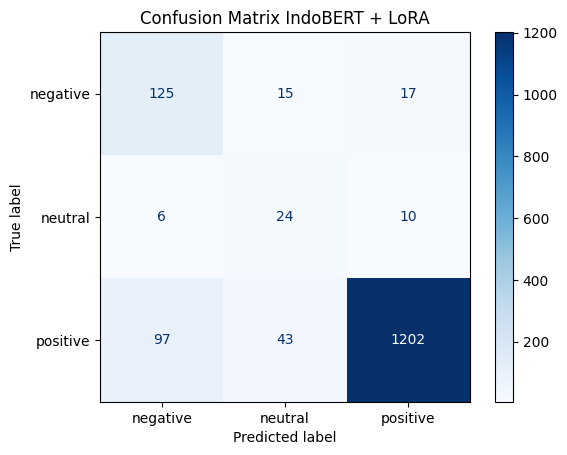

In [32]:
pred = trainer.predict(test_dataset)
y_pred = np.argmax(pred.predictions, axis=1)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix IndoBERT + LoRA")
plt.show()